# Event Finder

The goal of this notebook is to develop a generalized event finder. Based on user selected variable and event definitions, this notebook will search all simulations to find these events.  

Inputs:

* Domain
* Variable
* Low and/or High thresholds
* Duration 
* Global Warming Level

**Runtime**: With the default settings, this notebook takes approximately 27 minutes to run from start to finish. Modifications to selections may increase the runtime.

**Troubleshooting**: Kernel crashing? Try loading a smaller spatial area by setting the `latitude` and `longitude` variables or using a `cached_area`.

## Make Selections

Before running this notebook, make the following selections for variables, domain, and GWLs.

In [1]:
from climakitae.core.constants import UNSET
from climakitae.new_core.user_interface import ClimateData

cd = ClimateData()

2026-01-16 23:32:17 - climakitae.new_core.user_interface - INFO - Initializing ClimateData interface
2026-01-16 23:32:17 - climakitae.new_core.dataset_factory - INFO - DatasetFactory initialized with 3 validators and 10 processors
2026-01-16 23:32:17 - climakitae.new_core.user_interface - INFO - ClimateData initialization successful
2026-01-16 23:32:17 - climakitae.new_core.user_interface - INFO - ✅ Ready to query!


1. Select a timescale - this will impact which downscaling methods are available and which variables are available.

In [2]:
timescale = "day"  # options are 1hr, day, mon

2. Select a variable - the code below displays which variables are available based on your timescale options

Here are the options for dynamically downscaled (WRF) variables for selected timescale:

In [3]:
cd.activity_id("WRF").table_id(timescale).show_variable_options()

2026-01-16 23:32:17 - climakitae.new_core.user_interface - INFO - Activity ID set to: WRF
2026-01-16 23:32:17 - climakitae.new_core.user_interface - INFO - Table ID set to: day
2026-01-16 23:32:17 - climakitae.new_core.user_interface - INFO - Variables (constrained by current query)::
2026-01-16 23:32:17 - climakitae.new_core.user_interface - INFO - ------------------------------------------
2026-01-16 23:32:17 - climakitae.new_core.user_interface - INFO - cape:                    Convective Available Potential Energy
2026-01-16 23:32:17 - climakitae.new_core.user_interface - INFO - cf:                      Capacity factor
2026-01-16 23:32:17 - climakitae.new_core.user_interface - INFO - cin:                     Convective Inhibition
2026-01-16 23:32:17 - climakitae.new_core.user_interface - INFO - dew_point:               No description available
2026-01-16 23:32:17 - climakitae.new_core.user_interface - INFO - effective_temp_index:    No description available
2026-01-16 23:32:17 - cl

Here are the options for statistically downscaled (LOCA2) variables for the selected timescale. This is a smaller set than the dynamiclly downscaled variables. Daily average humidity and air temperature are not listed, but can be selected in this notebook by using "tas" or "hurs" (daily max and min will be averaged).

In [4]:
cd.activity_id("LOCA2").table_id(timescale).show_variable_options()

2026-01-16 23:32:17 - climakitae.new_core.user_interface - INFO - Activity ID set to: LOCA2
2026-01-16 23:32:17 - climakitae.new_core.user_interface - INFO - Table ID set to: day
2026-01-16 23:32:17 - climakitae.new_core.user_interface - INFO - Variables (constrained by current query)::
2026-01-16 23:32:17 - climakitae.new_core.user_interface - INFO - ------------------------------------------
2026-01-16 23:32:17 - climakitae.new_core.user_interface - INFO - hursmax:    Maximum relative humidity
2026-01-16 23:32:17 - climakitae.new_core.user_interface - INFO - hursmin:    Minimum relative humidity
2026-01-16 23:32:17 - climakitae.new_core.user_interface - INFO - huss:       Specific humidity at 2m
2026-01-16 23:32:17 - climakitae.new_core.user_interface - INFO - pr:         Precipitation (total)
2026-01-16 23:32:17 - climakitae.new_core.user_interface - INFO - rsds:       Shortwave flux at the surface
2026-01-16 23:32:17 - climakitae.new_core.user_interface - INFO - tasmax:     Maximum

In [5]:
# Make selection from lists above

# Dynamically downscaled variable (required)
event_variable_wrf = "prec"

# Set units
event_units_wrf = "inches/d"

# Statistically downscaled variable (optional)
# For "Relative humidity" use "hurs"
# For "Air Temperature at 2m" use "tas"
# For no variable use UNSET (no quotes)
event_variable_loca2 = "pr"

# Set units
event_units_loca2 = "inches"

3. Define Event - Select a method for establishing the event

In [6]:
# define the function that will be used to calculate the event threshold
event_threshold_function = "1 in x"  # options are "percentile" or "1 in x"
event_threshold_direction = (
    ">"  # look for events above or below the result from the threshold function
)
event_threshold_function_params = (
    10  # if 1 in X include X, if quantile, include quantile (0.25, 0.5, etc.)
)
event_duration = 1  # how many consecutive events need to be observed to be a hit

4. Select a baseline and future GWL

In [7]:
# current options 0.8, 1.0, 1.2, 1.5, 2.0, 2.5, 3.0, 4.0
baseline_gwl = 1.0
future_gwl = 2.0

5. Select Spatial Domain - A spatial domain can be selected via a lat/lon box, a cached area, or a user-provided shapefile. Selections can be made in the cell below.

For example, someone studying the Pajaro watershed might have a shapefile path that looks like this:
```
# User selection
spatial_domain = "Pajaro"
shapefile_filename = "PajaroRiverWatershed.zip"

# Other variables left unset:
lats = ()
lons = ()
cached_area = UNSET
```

In [8]:
# name will appear in title
spatial_domain = "CA"

# can define lat/lon box OR cached area OR shapefile
lats = ()  # () to leave undefined
lons = ()
cached_area = "Santa Cruz County"  # UNSET for no cached area

# edit filename below for shapefile to use
shapefile_filename = UNSET  # use UNSET for no shapefile

6. Select Resolution - select the the model resolution (3km, 9km, 45 km)

In [9]:
resolution = "d03"  # Options are d01 (45 km), d02 (9 km), or d03 (3 km)

7. Aggregation Method - select a method to aggregate spatially

In [10]:
aggregation = "median"  # options are mean, median, sum, min, max

8. Processes - choices for warming levels, units, and clipping are assembled into a dictionary of processes to apply to data selection.

In [11]:
# this dictionary is passed to the ClimateData catalog call when pulling data
process_dict = {
    "warming_level": {
        "warming_levels": [baseline_gwl],
    },
    "metric_calc": {"metric": aggregation, "dim": ["y", "x"]},
}

# add clipping selection
if (len(lats) > 0) and (len(lons) > 0):
    process_dict["clip"] = (lats, lons)
elif cached_area is not UNSET:
    process_dict["clip"] = [cached_area]
elif shapefile_filename is not UNSET:
    process_dict["clip"] = shapefile_filename
else:
    print("Process 'clip' unset.")

## Import libraries & define functions

In [12]:
!pip install seaborn

import climakitae as ck

from climakitae.util.utils import add_dummy_time_to_wl
from climakitae.explore.threshold_tools import (
    get_block_maxima,
    get_return_value,
)
from climakitae.core.data_load import load

import xarray as xr
import pandas as pd
import geopandas as gpd
from shapely.geometry import mapping
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## Step 1: Define Event 

Use the baseline GWL to define the event threshold

### Pull Baseline Data

#### Dynamical Downscaling (WRF)

In [13]:
process_dict.update({"convert_units": event_units_wrf})

wrf_data = (
    cd.catalog("cadcat")
    .activity_id("WRF")
    .institution_id("UCLA")
    .table_id(timescale)
    .grid_label(resolution)
    .variable(event_variable_wrf)
    .processes(process_dict)
    .get()
)

# add a dummy time variable
wrf_data = add_dummy_time_to_wl(wrf_data)

# load data
wrf_data = load(wrf_data, progress_bar=True).squeeze()

2026-01-16 23:32:18 - climakitae.new_core.user_interface - INFO - Catalog set to: cadcat
2026-01-16 23:32:18 - climakitae.new_core.user_interface - INFO - Activity ID set to: WRF
2026-01-16 23:32:18 - climakitae.new_core.user_interface - INFO - Institution ID set to: UCLA
2026-01-16 23:32:18 - climakitae.new_core.user_interface - INFO - Table ID set to: day
2026-01-16 23:32:18 - climakitae.new_core.user_interface - INFO - Grid label set to: d03
2026-01-16 23:32:18 - climakitae.new_core.user_interface - INFO - Variable set to: prec
2026-01-16 23:32:18 - climakitae.new_core.user_interface - INFO - Processes set: 4 operations configured
2026-01-16 23:32:18 - climakitae.new_core.user_interface - INFO - Starting data retrieval with query: {'catalog': 'cadcat', 'installation': UNSET, 'activity_id': 'WRF', 'institution_id': 'UCLA', 'source_id': UNSET, 'experiment_id': UNSET, 'table_id': 'day', 'grid_label': 'd03', 'variable_id': 'prec', 'station_id': UNSET, 'network_id': UNSET, 'processes': {

#### Statistical Downscaling (LOCA2)

In [14]:
if event_variable_loca2 is not UNSET:
    loca_variable = [event_variable_loca2]
    # temperature
    if loca_variable[0] == "tas":
        loca_variable = ["tasmax", "tasmin"]
    # relative humidity
    if loca_variable[0] == "hurs":
        loca_variable = ["hursmax", "hursmin"]

    process_dict.update({"convert_units": event_units_loca2})
    process_dict["metric_calc"].update({"dim": ["lat", "lon"]})

    # statistical - loca2 downscaling xvariable
    loca_data = [
        cd.catalog("cadcat")
        .activity_id("LOCA2")
        .table_id(timescale)
        .grid_label(resolution)
        .variable(GETVAR)
        .processes(process_dict)
        .get()
        for GETVAR in loca_variable
    ]

    # if we need to average
    if event_variable_loca2 in ["tas", "hurs"]:
        loca_data = (
            loca_data[0][loca_variable[0]] + loca_data[1][loca_variable[1]]
        ) / 2
        loca_data = loca_data.to_dataset(name=event_variable_loca2)
        loca_data.attrs["frequency"] = timescale

    # unlist if needed
    if type(loca_data) == list:
        loca_data = loca_data[0]

    # add a dummy time variable
    loca_data = add_dummy_time_to_wl(loca_data)

    # load data
    loca_data = load(loca_data, progress_bar=True).squeeze()

    # reset to WRF values
    process_dict["metric_calc"].update({"dim": ["x", "y"]})
else:
    # set to wrf
    loca_data = wrf_data
    # replace with all NaNs
    loca_data = loca_data * np.nan

2026-01-16 23:32:40 - climakitae.new_core.user_interface - INFO - Catalog set to: cadcat
2026-01-16 23:32:40 - climakitae.new_core.user_interface - INFO - Activity ID set to: LOCA2
2026-01-16 23:32:40 - climakitae.new_core.user_interface - INFO - Table ID set to: day
2026-01-16 23:32:40 - climakitae.new_core.user_interface - INFO - Grid label set to: d03
2026-01-16 23:32:40 - climakitae.new_core.user_interface - INFO - Variable set to: pr
2026-01-16 23:32:40 - climakitae.new_core.user_interface - INFO - Processes set: 4 operations configured
2026-01-16 23:32:40 - climakitae.new_core.user_interface - INFO - Starting data retrieval with query: {'catalog': 'cadcat', 'installation': UNSET, 'activity_id': 'LOCA2', 'institution_id': UNSET, 'source_id': UNSET, 'experiment_id': UNSET, 'table_id': 'day', 'grid_label': 'd03', 'variable_id': 'pr', 'station_id': UNSET, 'network_id': UNSET, 'processes': {'warming_level': {'warming_levels': [1.0]}, 'metric_calc': {'metric': 'median', 'dim': ['lat', 

### Define Event

In [15]:
# determine what method to define event
if event_threshold_function == "percentile":
    # calculate the percentile
    loca_threshold = (
        loca_data[event_variable_loca2]
        .quantile(dim="time", q=event_threshold_function_params)
        .squeeze()
    )
    wrf_threshold = (
        wrf_data[event_variable_wrf]
        .quantile(dim="time", q=event_threshold_function_params)
        .squeeze()
    )

# if 1 in x
if event_threshold_function == "1 in x":
    if event_threshold_direction == ">":
        extreme_type = "max"
    else:
        extreme_type = "min"
    # initialize
    loca_list = []
    for sim in loca_data.sim:
        loca_ams = get_block_maxima(
            loca_data[event_variable_loca2].sel({"sim": sim}),
            check_ess=False,
            extremes_type=extreme_type,
        )
        loca_rv = get_return_value(
            loca_ams,
            return_period=event_threshold_function_params,
            multiple_points=False,
        )
        loca_rv = loca_rv.expand_dims(dim="sim")
        loca_list.append(loca_rv)
    loca_threshold = xr.concat(loca_list, loca_data.sim)
    loca_threshold = loca_threshold["return_value"].squeeze()
    # intalize
    wrf_list = []
    for sim in wrf_data.sim:
        wrf_ams = get_block_maxima(
            wrf_data[event_variable_wrf].sel({"sim": sim}),
            check_ess=False,
            extremes_type=extreme_type,
        )
        wrf_rv = get_return_value(
            wrf_ams,
            return_period=event_threshold_function_params,
            multiple_points=False,
        )
        wrf_rv = wrf_rv.expand_dims(dim="sim")
        wrf_list.append(wrf_rv)
    wrf_threshold = xr.concat(wrf_list, wrf_data.sim)
    wrf_threshold = wrf_threshold["return_value"].squeeze()

In [16]:
# remove baseline data to free up memory
del loca_data
del wrf_data

## Step 2: Estimate Event 'Hits'

Use the future GWL to estimate event hits

### Pull Future GWL Data

#### Dynamical Downscaling (WRF)

In [17]:
# WRF downscaling
process_dict.update({"warming_level": {"warming_levels": [future_gwl]}})
process_dict.update({"convert_units": event_units_wrf})

wrf_data = (
    cd.catalog("cadcat")
    .activity_id("WRF")
    .institution_id("UCLA")
    .table_id(timescale)
    .grid_label(resolution)
    .variable(event_variable_wrf)
    .processes(process_dict)
    .get()
)

# add a dummy time variable
wrf_data = add_dummy_time_to_wl(wrf_data)

# If simulation is missing in baseline dataset,
# drop from future.
wrf_data = wrf_data.sel({"sim": wrf_threshold.sim.data})

# load data
wrf_data = load(wrf_data, progress_bar=True).squeeze()

2026-01-16 23:47:18 - climakitae.new_core.user_interface - INFO - Catalog set to: cadcat
2026-01-16 23:47:19 - climakitae.new_core.user_interface - INFO - Activity ID set to: WRF
2026-01-16 23:47:19 - climakitae.new_core.user_interface - INFO - Institution ID set to: UCLA
2026-01-16 23:47:19 - climakitae.new_core.user_interface - INFO - Table ID set to: day
2026-01-16 23:47:19 - climakitae.new_core.user_interface - INFO - Grid label set to: d03
2026-01-16 23:47:19 - climakitae.new_core.user_interface - INFO - Variable set to: prec
2026-01-16 23:47:19 - climakitae.new_core.user_interface - INFO - Processes set: 4 operations configured
2026-01-16 23:47:19 - climakitae.new_core.user_interface - INFO - Starting data retrieval with query: {'catalog': 'cadcat', 'installation': UNSET, 'activity_id': 'WRF', 'institution_id': 'UCLA', 'source_id': UNSET, 'experiment_id': UNSET, 'table_id': 'day', 'grid_label': 'd03', 'variable_id': 'prec', 'station_id': UNSET, 'network_id': UNSET, 'processes': {

#### Statistical Downscaling (LOCA2)

In [18]:
if event_variable_loca2 is not UNSET:
    # grab correct variable name for LOCA2
    loca_variable = [event_variable_loca2]
    # temperature
    if loca_variable[0] == "tas":
        loca_variable = ["tasmax", "tasmin"]
    # relative humidity
    if loca_variable[0] == "hurs":
        loca_variable = ["hursmax", "hursmin"]

    process_dict.update({"convert_units": event_units_loca2})
    process_dict["metric_calc"].update({"dim": ["lat", "lon"]})

    # statistical - loca2 downscaling xvariable
    loca_data = [
        cd.catalog("cadcat")
        .activity_id("LOCA2")
        .table_id(timescale)
        .grid_label(resolution)
        .variable(GETVAR)
        .processes(process_dict)
        .get()
        for GETVAR in loca_variable
    ]

    # if we need to average
    if event_variable_loca2 in ["tas", "hurs"]:
        loca_data = (
            loca_data[0][loca_variable[0]] + loca_data[1][loca_variable[1]]
        ) / 2
        loca_data = loca_data.to_dataset(name=event_variable_loca2)
        loca_data.attrs["frequency"] = timescale

    # pull data from list if needed
    if type(loca_data) == list:
        loca_data = loca_data[0]

    # add a dummy time variable
    loca_data = add_dummy_time_to_wl(loca_data)

    # If simulation is missing in baseline dataset,
    # drop from future.
    loca_data = loca_data.sel({"sim": loca_threshold.sim.data})

    # load data
    loca_data = load(loca_data, progress_bar=True).squeeze()

    # reset to WRF values
    process_dict["metric_calc"].update({"dim": ["x", "y"]})
else:
    # set to wrf
    loca_data = wrf_data
    # replace with all NaNs
    loca_data = loca_data * np.nan

2026-01-16 23:47:35 - climakitae.new_core.user_interface - INFO - Catalog set to: cadcat
2026-01-16 23:47:35 - climakitae.new_core.user_interface - INFO - Activity ID set to: LOCA2
2026-01-16 23:47:35 - climakitae.new_core.user_interface - INFO - Table ID set to: day
2026-01-16 23:47:35 - climakitae.new_core.user_interface - INFO - Grid label set to: d03
2026-01-16 23:47:35 - climakitae.new_core.user_interface - INFO - Variable set to: pr
2026-01-16 23:47:35 - climakitae.new_core.user_interface - INFO - Processes set: 4 operations configured
2026-01-16 23:47:35 - climakitae.new_core.user_interface - INFO - Starting data retrieval with query: {'catalog': 'cadcat', 'installation': UNSET, 'activity_id': 'LOCA2', 'institution_id': UNSET, 'source_id': UNSET, 'experiment_id': UNSET, 'table_id': 'day', 'grid_label': 'd03', 'variable_id': 'pr', 'station_id': UNSET, 'network_id': UNSET, 'processes': {'warming_level': {'warming_levels': [2.0]}, 'metric_calc': {'metric': 'median', 'dim': ['lat', 

### Count Hits

In [19]:
### create a 'hit' for in events
# initialize an array to fill
wrfEventHit = np.zeros(wrf_data[event_variable_wrf].shape)
if event_variable_loca2 is not UNSET:
    locaEventHit = np.zeros(loca_data[event_variable_loca2].shape)
else:
    locaEventHit = wrfEventHit

# loop through each time stamp
for itime in range(0, len(wrf_data["time"])):
    # look at this time stamp + duration
    timeIndex = list(range(itime, (itime + event_duration)))
    # remove any values that are greater than our time
    timeIndex = [x for x in timeIndex if x < len(wrf_data["time"])]

    ### Start with WRF
    # pull out the data to test
    testWRFData = wrf_data[event_variable_wrf][:, timeIndex]

    # for each simulation, check if the values are greater or less than the threshold
    if event_threshold_direction == "<":
        wrfCounts = (testWRFData < wrf_threshold).sum(dim="time")
    if event_threshold_direction == ">":
        wrfCounts = (testWRFData > wrf_threshold).sum(dim="time")

    # if you have greater than or equal to duration count as a 'hit'
    wrfHitIndex = wrfCounts >= event_duration

    # now save hits
    wrfEventHit[wrfHitIndex, itime] = 1

    ### Move to Loca
    if event_variable_loca2 is not UNSET:
        # pull out the data to test
        testLOCAData = loca_data[event_variable_loca2][:, timeIndex]

        # for each simulation, check if the values are greater or less than the threshold
        if event_threshold_direction == "<":
            locaCounts = (testLOCAData < loca_threshold).sum(dim="time")
        if event_threshold_direction == ">":
            locaCounts = (testLOCAData > loca_threshold).sum(dim="time")

        # if you have greater than or equal to duration count as a 'hit'
        locaHitIndex = locaCounts >= event_duration

        # now save hits
        locaEventHit[locaHitIndex, itime] = 1

In [20]:
# now add hits to xarray
wrf_data = wrf_data.assign_coords(event_hit=(("sim", "time"), wrfEventHit))
loca_data = loca_data.assign_coords(event_hit=(("sim", "time"), locaEventHit))

# Rename so that there's only a single variable in the final dataframe
if event_variable_loca2 is not UNSET:
    loca_data = loca_data.rename({event_variable_loca2: event_variable_wrf})

## Prep for Plotting

In [21]:
wsims = wrf_data.sim.values.tolist()
wrf_models = [s.split("_")[2] for s in wsims]
wrf_data = wrf_data.assign_coords(models=("sim", wrf_models))

# create a realization variable
wrf_realization = [s.split("_")[3] + "_" + s.split("_")[6] for s in wsims]
wrf_data = wrf_data.assign_coords(realization=("sim", wrf_realization))

# create a data frame to make plotting easier
wrfDF = wrf_data.to_dataframe().reset_index()

# Create a downscaling name
wrfDF["downscaling"] = "wrf"

In [22]:
if event_variable_loca2 is not UNSET:
    # create a 'model' variable
    lsims = loca_data.sim.values.tolist()
    loca_models = [s.split("_")[2] for s in lsims]
    loca_data = loca_data.assign_coords(models=("sim", loca_models))

    # create a realization variable
    loca_realization = [s.split("_")[3] + "_" + s.split("_")[6] for s in lsims]
    loca_data = loca_data.assign_coords(realization=("sim", loca_realization))

    # create a data frame to make plotting easier
    locaDF = loca_data.to_dataframe().reset_index()

    locaDF["downscaling"] = "loca2"
else:
    # Just an empty dataframe
    locaDF = pd.DataFrame()

In [23]:
# combine into one
finalDF = pd.concat([locaDF, wrfDF], keys=wrfDF.keys())

## Step 3: Plot Results (Yay!)

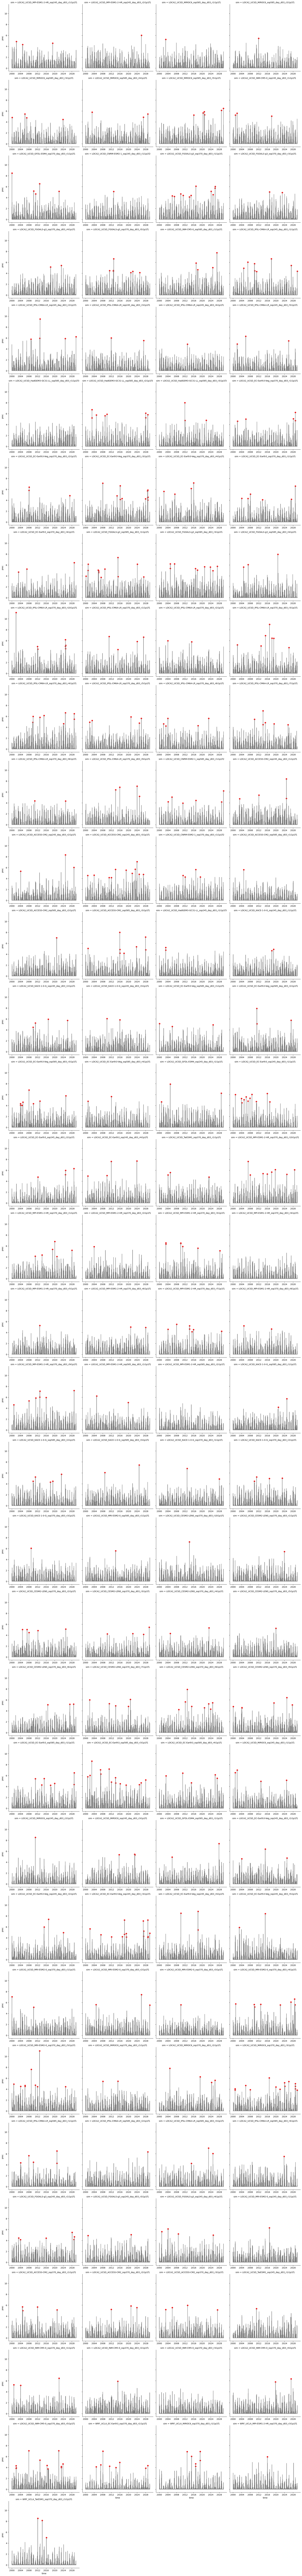

In [24]:
# plot all the data
def annotate(data, **kws):
    ax = plt.gca()
    ax.scatter(
        data.time.where(data.event_hit == 1),
        data[event_variable_wrf].where(data.event_hit == 1),
        color="r",
    )


g1 = sns.relplot(
    data=finalDF,
    x="time",
    y=event_variable_wrf,
    col="sim",
    color="grey",
    col_wrap=4,
    kind="line",
    height=5,
    aspect=1,
    facet_kws=dict(sharex=False),
)
g1.map_dataframe(annotate)

In [25]:
# Save the figure to a file
if event_threshold_function == "1 in x":
    event_name = f"1_in_{event_threshold_function_params}"
else:
    event_name = f"{event_threshold_function_params}_percentile"
g1.savefig(
    f"event_finder_{event_variable_wrf}_under_{future_gwl}gwl_with_{event_name}_{event_duration}{timescale}duration_{spatial_domain}.jpeg".replace(
        " ", "_"
    )
)

In [26]:
# save event data
finalDF.to_parquet(
    f"event_{event_variable_wrf}_under_{future_gwl}gwl_with_{event_name}_{event_duration}{timescale}duration_{spatial_domain}".replace(
        " ", "_"
    )
)